# Histogram Operations

![Task](pics/task.jpg)

In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
%matplotlib inline

K = 255
x = np.arange(K + 1)

In [2]:
def cv_hist(img):
    hist_size = K + 1
    hist_range = (0, K)
    hist = cv.calcHist([img], [0], None, [hist_size], hist_range, accumulate=False)
    return hist.flatten()

def my_hist(img):
    hist = np.zeros(K + 1)
    for pixel in img.flatten():
        hist[pixel] += 1
    return hist

In [3]:
tiger = cv.imread('pics/tiger.png', 0)
lion = cv.imread('pics/lion.jpg', 0)
wolf = cv.imread('pics/wolf.jpg', 0)

# Линейное растяжение гистограммы

In [4]:
np.all(cv_hist(tiger) == my_hist(tiger)) # compare to cv

True

In [5]:
def stretch(img):
    return ((img - img.min()) / (img.max() - img.min()) * K).astype('uint8')

In [6]:
def plot_stretch(img, name):
    img_hist = my_hist(img)
    stretched = stretch(img)
    stretched_hist = my_hist(stretched)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    axes[0][0].imshow(img, cmap='gray', vmin=0, vmax=K)
    axes[0][0].set_title('Исходное изображение')
    axes[0][0].axis('off')

    axes[0][1].plot(x, img_hist)
    axes[0][1].set_title('Гистограмма')
    
    axes[1][0].imshow(stretched, cmap='gray', vmin=0, vmax=K)
    axes[1][0].set_title('Изображение после линейного растяжения гистограммы')
    axes[1][0].axis('off')
    
    axes[1][1].plot(x, stretched_hist)
    axes[1][1].set_title('Гистограмма после линейного растяжения')

    fig.tight_layout()
    plt.savefig('pics/' + name + '_stretch.png')
    plt.show()

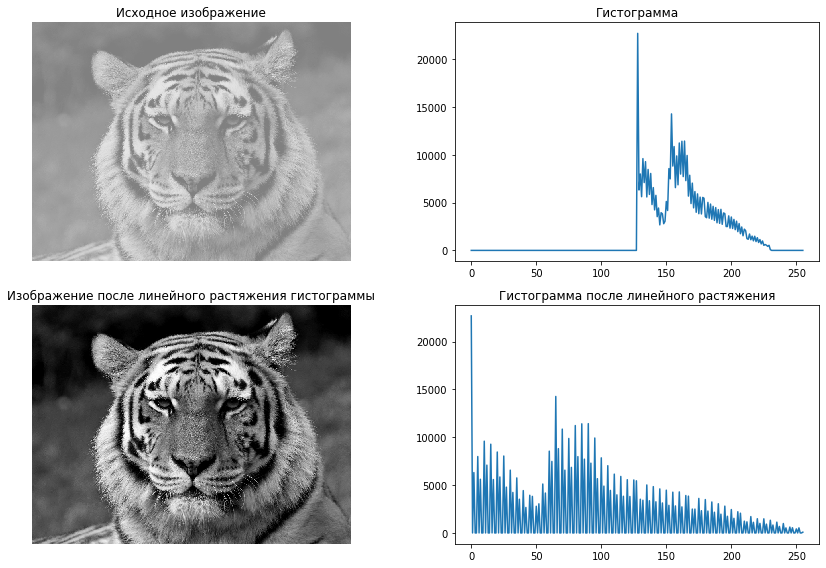

In [7]:
plot_stretch(tiger, 'tiger')

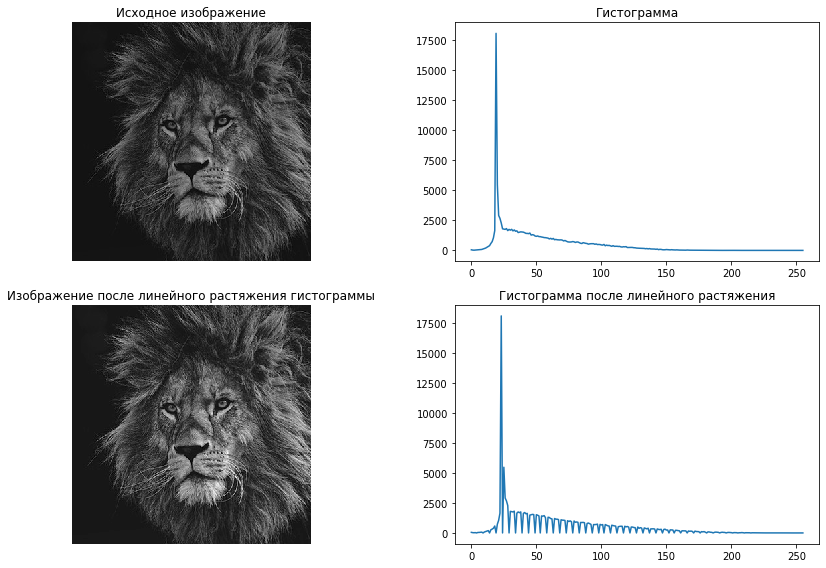

In [8]:
plot_stretch(lion, 'lion')

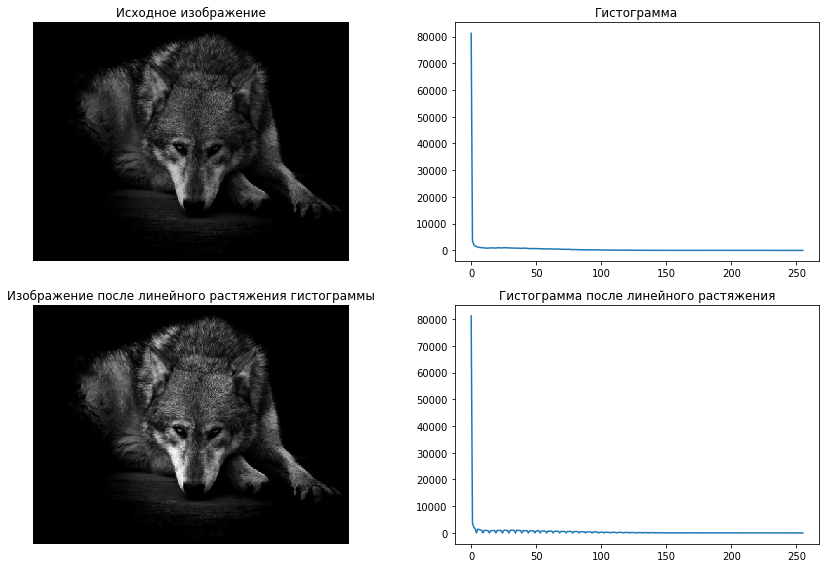

In [9]:
plot_stretch(wolf, 'wolf')

## Устойчивый автоконтраст

In [10]:
def find_min_and_max(img, hist, drop=0.05):    
    k = int(drop * img.size)
    x_min, x_max = 0, 0

    cnt = 0
    for i in np.arange(K + 1):
        cnt += hist[i]
        if cnt >= k:
            x_min = i
            break

    cnt = 0
    for i in np.arange(K - 1, -1, -1):
        cnt += hist[i]
        if cnt >= k:
            x_max = i
            break
            
    return x_min, x_max

def stable_stretch(img, x_min, x_max):
    img = img.astype('float')
    corrected = (img - x_min) / (x_max - x_min) * K
    res = np.clip(corrected, 0, K)
    return res.astype('uint8')

In [11]:
def plot_stable_stretch(img, name, drop=0.05):
    img_hist = my_hist(img)
    (x_min, x_max) = find_min_and_max(img, img_hist, drop=drop)
    stable = stable_stretch(img, x_min, x_max)
    stable_hist = cv_hist(stable)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    axes[0][0].imshow(img, cmap='gray', vmin=0, vmax=K)
    axes[0][0].set_title('Исходное изображение')
    axes[0][0].axis('off')

    axes[0][1].plot(x, img_hist)
    axes[0][1].axvline(x_min, c='r')
    axes[0][1].axvline(x_max, c='r')
    axes[0][1].set_title('Гистограмма исходного изображения')

    axes[1][0].imshow(stable, cmap='gray', vmin=0, vmax=K)
    axes[1][0].set_title('Изображение после устойчивого линейного растяжения гистограммы')
    axes[1][0].axis('off')
    
    axes[1][1].plot(x, stable_hist)
    axes[1][1].set_title('Гистограмма после устойчивого линейного растяжения')

    fig.tight_layout()
    plt.savefig('pics/' + name + '_stretch_stable.png')
    plt.show()
    

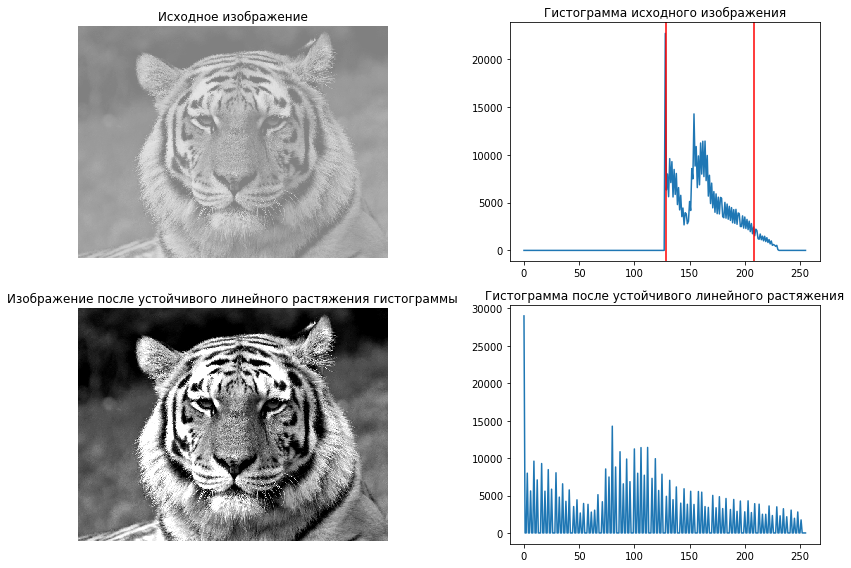

In [12]:
plot_stable_stretch(tiger, 'tiger')

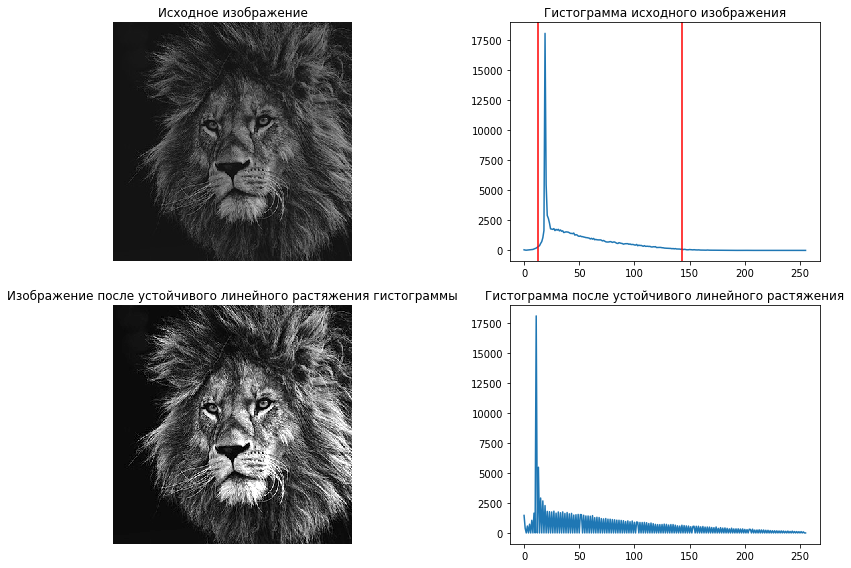

In [13]:
plot_stable_stretch(lion, 'lion', drop=0.01)

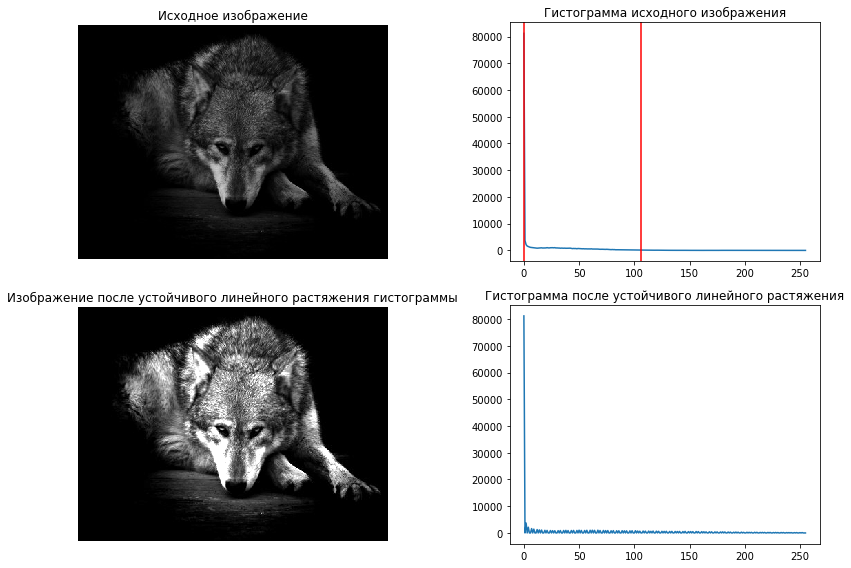

In [14]:
plot_stable_stretch(wolf, 'wolf', drop=0.02)

# Эквилизация гистограммы

In [15]:
def my_cumsum(hist):
    cdf = hist.copy()
    for i in np.arange(1, hist.size):
        cdf[i] = cdf[i - 1] + cdf[i]
    return cdf

np.all(my_cumsum(my_hist(tiger)) == np.cumsum(my_hist(tiger))) # compare to numpy

True

In [16]:
def equalize(x, cdf, cdf_min):
    return np.round((cdf[x] - cdf_min) / (cdf[-1]) * K).astype('uint8')

In [17]:
def plot_equalize(img, name):
    img_hist = my_hist(img)
    img_cdf = my_cumsum(img_hist)
    img_cdf_min = np.nonzero(img_cdf)[0][0] # first non-zero hist bin
    img_cdf_norm = img_cdf * img_hist.max() / img_cdf.max()
    
    equalized = equalize(img, img_cdf, img_cdf_min)
    equalized_hist = my_hist(equalized)
    equalized_cdf = my_cumsum(equalized_hist)
    equalized_cdf_norm = equalized_cdf * equalized_hist.max() / equalized_cdf.max()
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    axes[0][0].imshow(img, cmap='gray', vmin=0, vmax=K)
    axes[0][0].set_title('Исходное изображение')
    axes[0][0].axis('off')

    axes[0][1].plot(x, img_hist)
    axes[0][1].plot(x, img_cdf_norm, c="r")
    axes[0][1].set_title('Исходная гистограмма и функция распределения')
    
    axes[1][0].imshow(equalized, cmap='gray', vmin=0, vmax=K)
    axes[1][0].set_title('Изображение после эквилизации')
    axes[1][0].axis('off')
    
    axes[1][1].plot(x, equalized_hist)
    axes[1][1].plot(x, equalized_cdf_norm, c="r")
    axes[1][1].set_title('Гистограмма и функция распределения после эквализации')

    fig.tight_layout()
    plt.savefig('pics/' + name + '_equalized.png')
    plt.show()

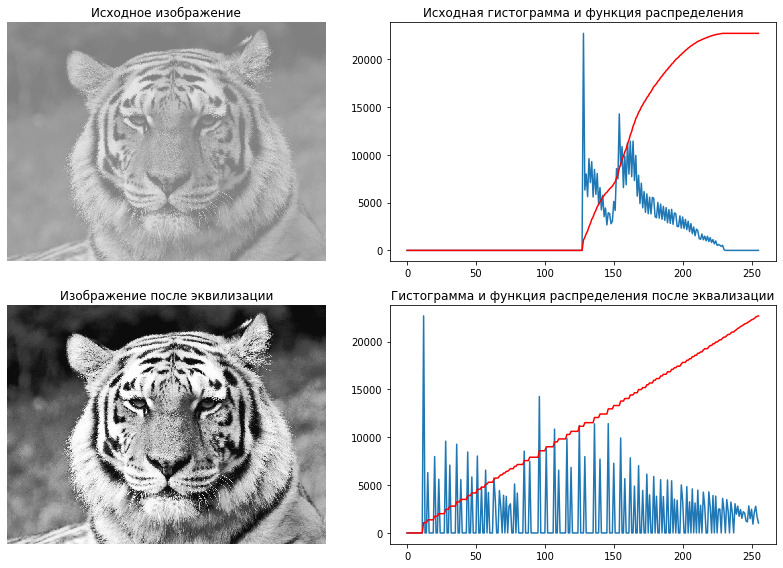

In [18]:
plot_equalize(tiger, 'tiger')

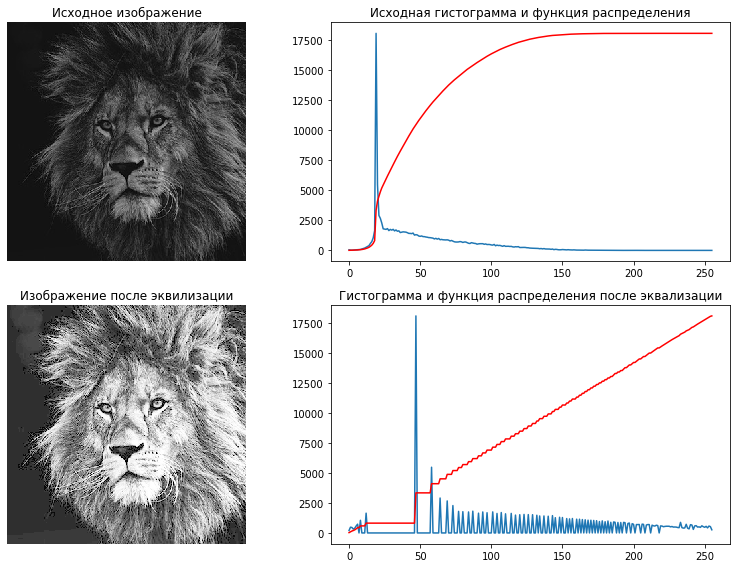

In [19]:
plot_equalize(lion, 'lion')

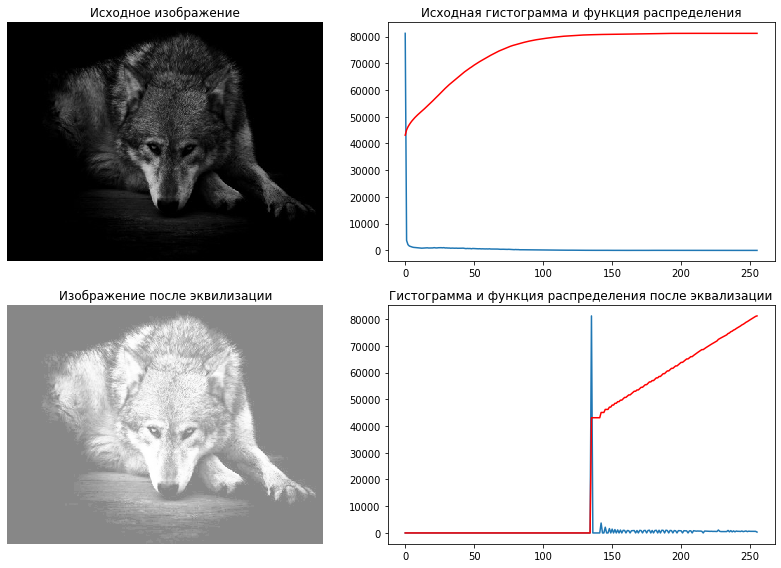

In [20]:
plot_equalize(wolf, 'wolf')

# Приведение гистограммы

In [21]:
def match_histogram(img, ref):
    res = img.copy()
    
    img_hist = my_hist(img)
    img_cdf = my_cumsum(img_hist)
    img_cdf_norm = img_cdf / img.size
    
    ref_hist = my_hist(ref)
    ref_cdf = my_cumsum(ref_hist)
    ref_cdf_norm = ref_cdf / ref.size
    
    mapping = np.zeros(K + 1)
    for i in np.arange(K + 1):
        j = K
        while True:
            mapping[i] = j
            j = j - 1
            if j < 0 or img_cdf_norm[i] > ref_cdf_norm[j]:
                break

    for i in np.arange(res.shape[0]):
        for j in np.arange(res.shape[1]):
            a = res.item(i,j)
            b = mapping[a]
            res.itemset((i,j), b)
            
    return res

In [22]:
def plot_histogram_match(img, ref, name):
    img_hist = my_hist(img)
    img_cdf = my_cumsum(img_hist)
    img_cdf_norm = img_cdf * img_hist.max() / img_cdf.max()
    
    ref_hist = my_hist(ref)
    ref_cdf = my_cumsum(ref_hist)
    ref_cdf_norm = ref_cdf * ref_hist.max() / ref_cdf.max()

    matched = match_histogram(img, ref)
    matched_hist = my_hist(matched)
    matched_cdf = my_cumsum(matched_hist)
    matched_cdf_norm = matched_cdf * matched_hist.max() / matched_cdf.max()
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

    axes[0][0].imshow(img, cmap='gray', vmin=0, vmax=K)
    axes[0][0].set_title('Исходное изображение')
    axes[0][0].axis('off')

    axes[0][1].plot(x, img_hist)
    axes[0][1].plot(x, img_cdf_norm, c="r")
    axes[0][1].set_title('Исходная гистограмма и функция распределения')

    axes[1][0].imshow(ref, cmap='gray', vmin=0, vmax=K)
    axes[1][0].set_title('Референсное изображение')
    axes[1][0].axis('off')

    axes[1][1].plot(x, ref_hist)
    axes[1][1].plot(x, ref_cdf_norm, c="r")
    axes[1][1].set_title('Гистограмма и функция распределения референсного изображения')
    
    axes[2][0].imshow(matched, cmap='gray', vmin=0, vmax=K)
    axes[2][0].set_title('Изображение после приведения гистограммы')
    axes[2][0].axis('off')

    axes[2][1].plot(x, matched_hist)
    axes[2][1].plot(x, matched_cdf_norm, c="r")
    axes[2][1].set_title('Гистограмма и функция распределения после приведения гистограммы')

    fig.tight_layout()
    plt.savefig('pics/' + name + '_macthed.png')
    plt.show()

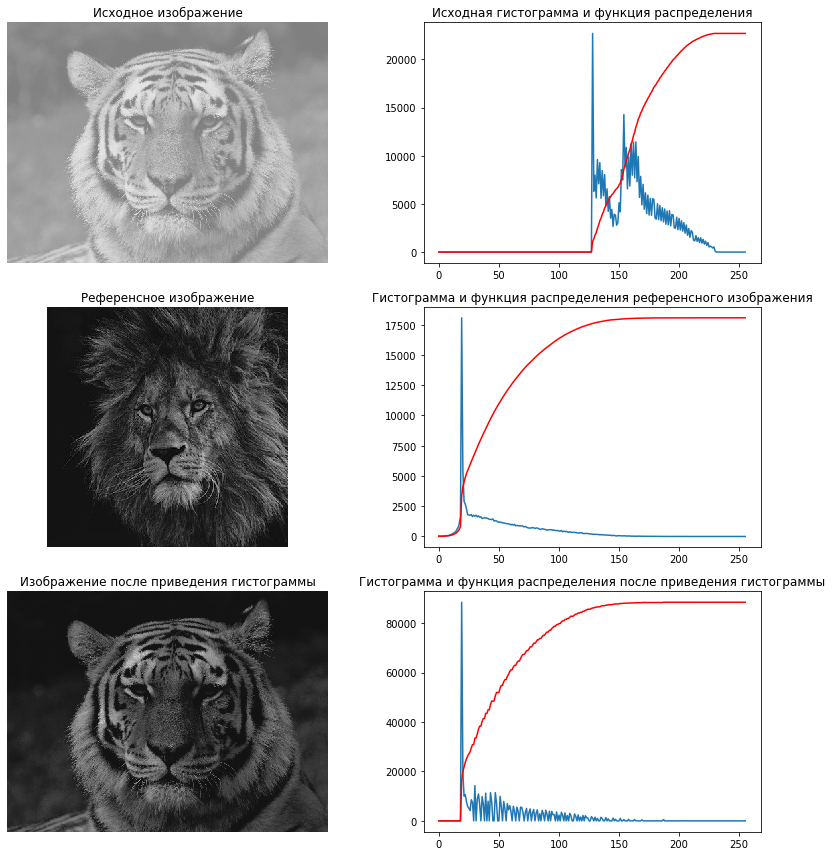

In [23]:
plot_histogram_match(tiger, lion, 'tiger_lion')

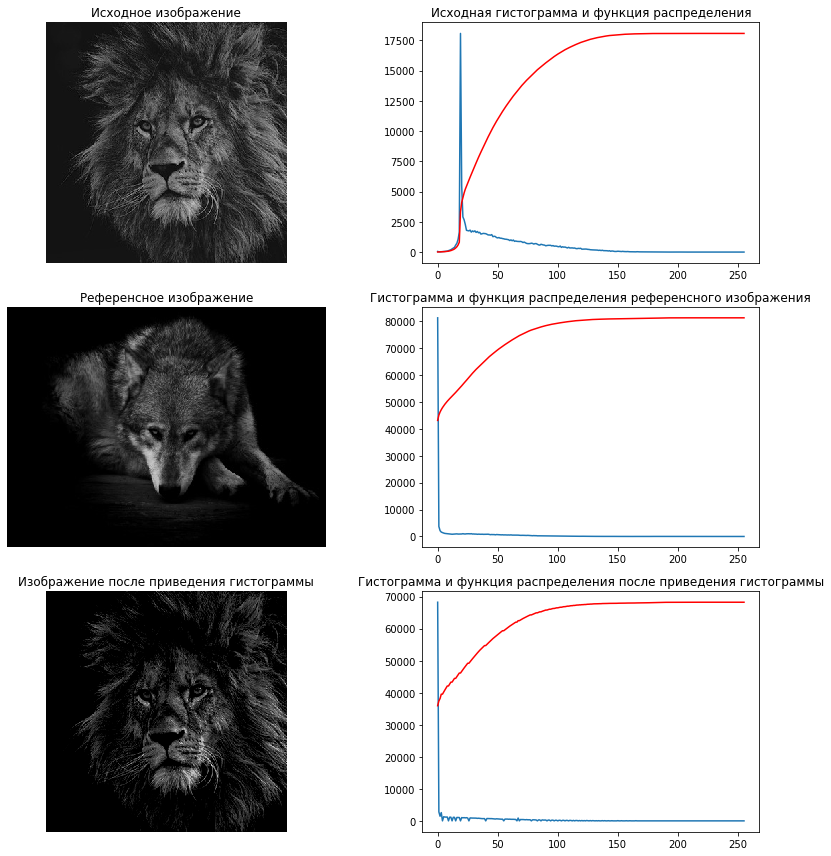

In [24]:
plot_histogram_match(lion, wolf, 'lion_wolf')